# RF antenna: microstrip fed patch
We simulate a narrowband patch antenna fed by a microstrip line around 1.5 GHz. Compare with [COMSOL example](https://www.comsol.com/model/microstrip-patch-antenna-11742).

## Geometry

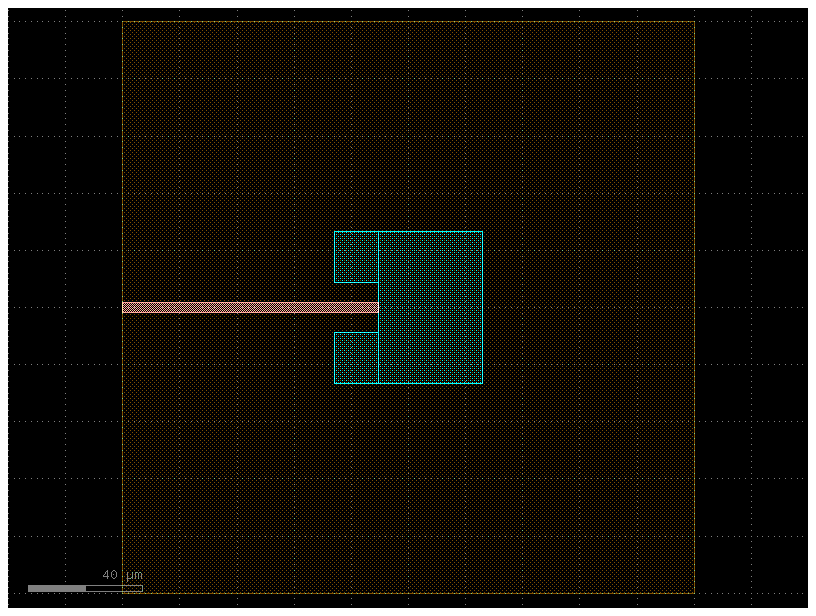

In [3]:
import luminescent as lumi
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
import gdsfactory as gf
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import Image

# simulation folder
path = os.path.join("runs", "patch")

# length and frequency units are arbitrary but must be consistent
frequency = 1.575  # GHz
wl1f = 300  # vacuum wavelength at 1 unit of frequency in your units in this case mm
wavelength = wl1f / frequency  # characteristic wavelength
frequencies = np.linspace(1.5, 1.6, 51).tolist()

# microstrip patch [mm]
d = 0001.524 # Substrate depth
w_line = 3.2 # 50 ohm line width
w_patch = 53 # Patch width
l_patch = 52 # Patch length
w_slot = 7 # slot width
l_flap = 15.5 # flap or slot length
w_flap=w_patch/2-w_slot-w_line/2
w_sub = 200 # Substrate width
l_sub = 200 # Substrate length
th=.1 # metal thickness

lateral_port_margin = height_port_margin = 3*d
source_port_margin =  1.*(w_line+2*lateral_port_margin)

# layers
WG = 1, 0
PATCH = 2, 0
SUB= 3, 0

# make geometry in gdsfadory
# alternatively can import .gds into gdsfadory

c = gf.Component()

c.add_polygon(
    [
        (-l_patch / 2, -w_patch / 2),
        (-l_patch / 2 + l_flap, -w_patch / 2),
        (-l_patch / 2 + l_flap, -w_patch / 2 + w_flap),
        (-l_patch / 2, -w_patch / 2 + w_flap),
    ],
    layer=PATCH,
)
c.add_polygon(
    [
        (-l_patch / 2, w_patch / 2),
        (-l_patch / 2 + l_flap, w_patch / 2),
        (-l_patch / 2 + l_flap, w_patch / 2 - w_flap),
        (-l_patch / 2, w_patch / 2 - w_flap),
    ],
    layer=PATCH,
)
c.add_polygon(
    [
        (l_patch / 2, -w_patch / 2),
        (-l_patch / 2 + l_flap, -w_patch / 2),
        (-l_patch / 2 + l_flap, w_patch / 2),
        (l_patch / 2, w_patch / 2),
    ],
    layer=PATCH,
)

c.add_polygon(
    [
        (-l_sub / 2, -w_sub / 2),
        (-l_sub / 2, w_sub / 2),
        (l_sub / 2, w_sub / 2),
        (l_sub / 2, -w_sub / 2),
    ],
    layer=SUB,
)

line = c << gf.components.straight((l_sub - l_patch) / 2 + l_flap, width=w_line)
line.movex(-l_sub / 2)
c.add_port(
    f"o1", center=(-l_patch / 2, 0), width=w_line, orientation=180, layer=WG
)

c.plot()

## Solve

Solving port modes with FEM...


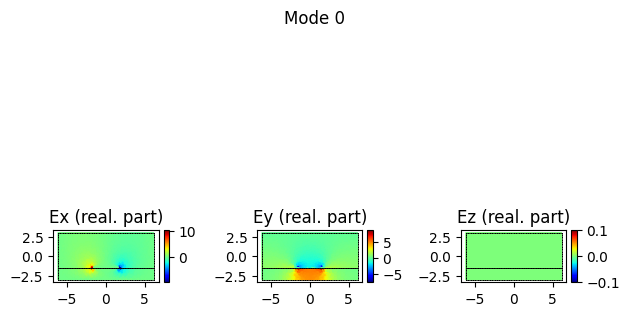

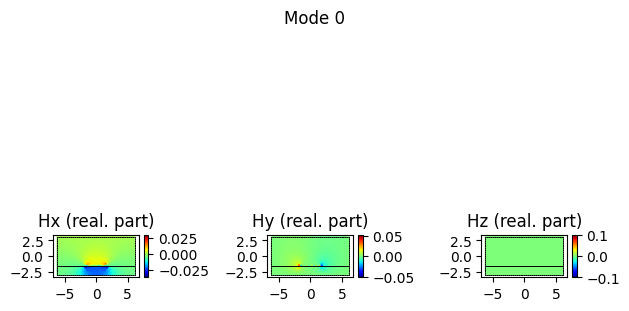

c:\Users\default.LAPTOP-HMRU58MH\anaconda3\Lib\site-packages\skfem\assembly\form\linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)


using simulation folder c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\patch
Video generated successfully at runs\patch\simulation.mp4 and runs\patch\simulation.gif!


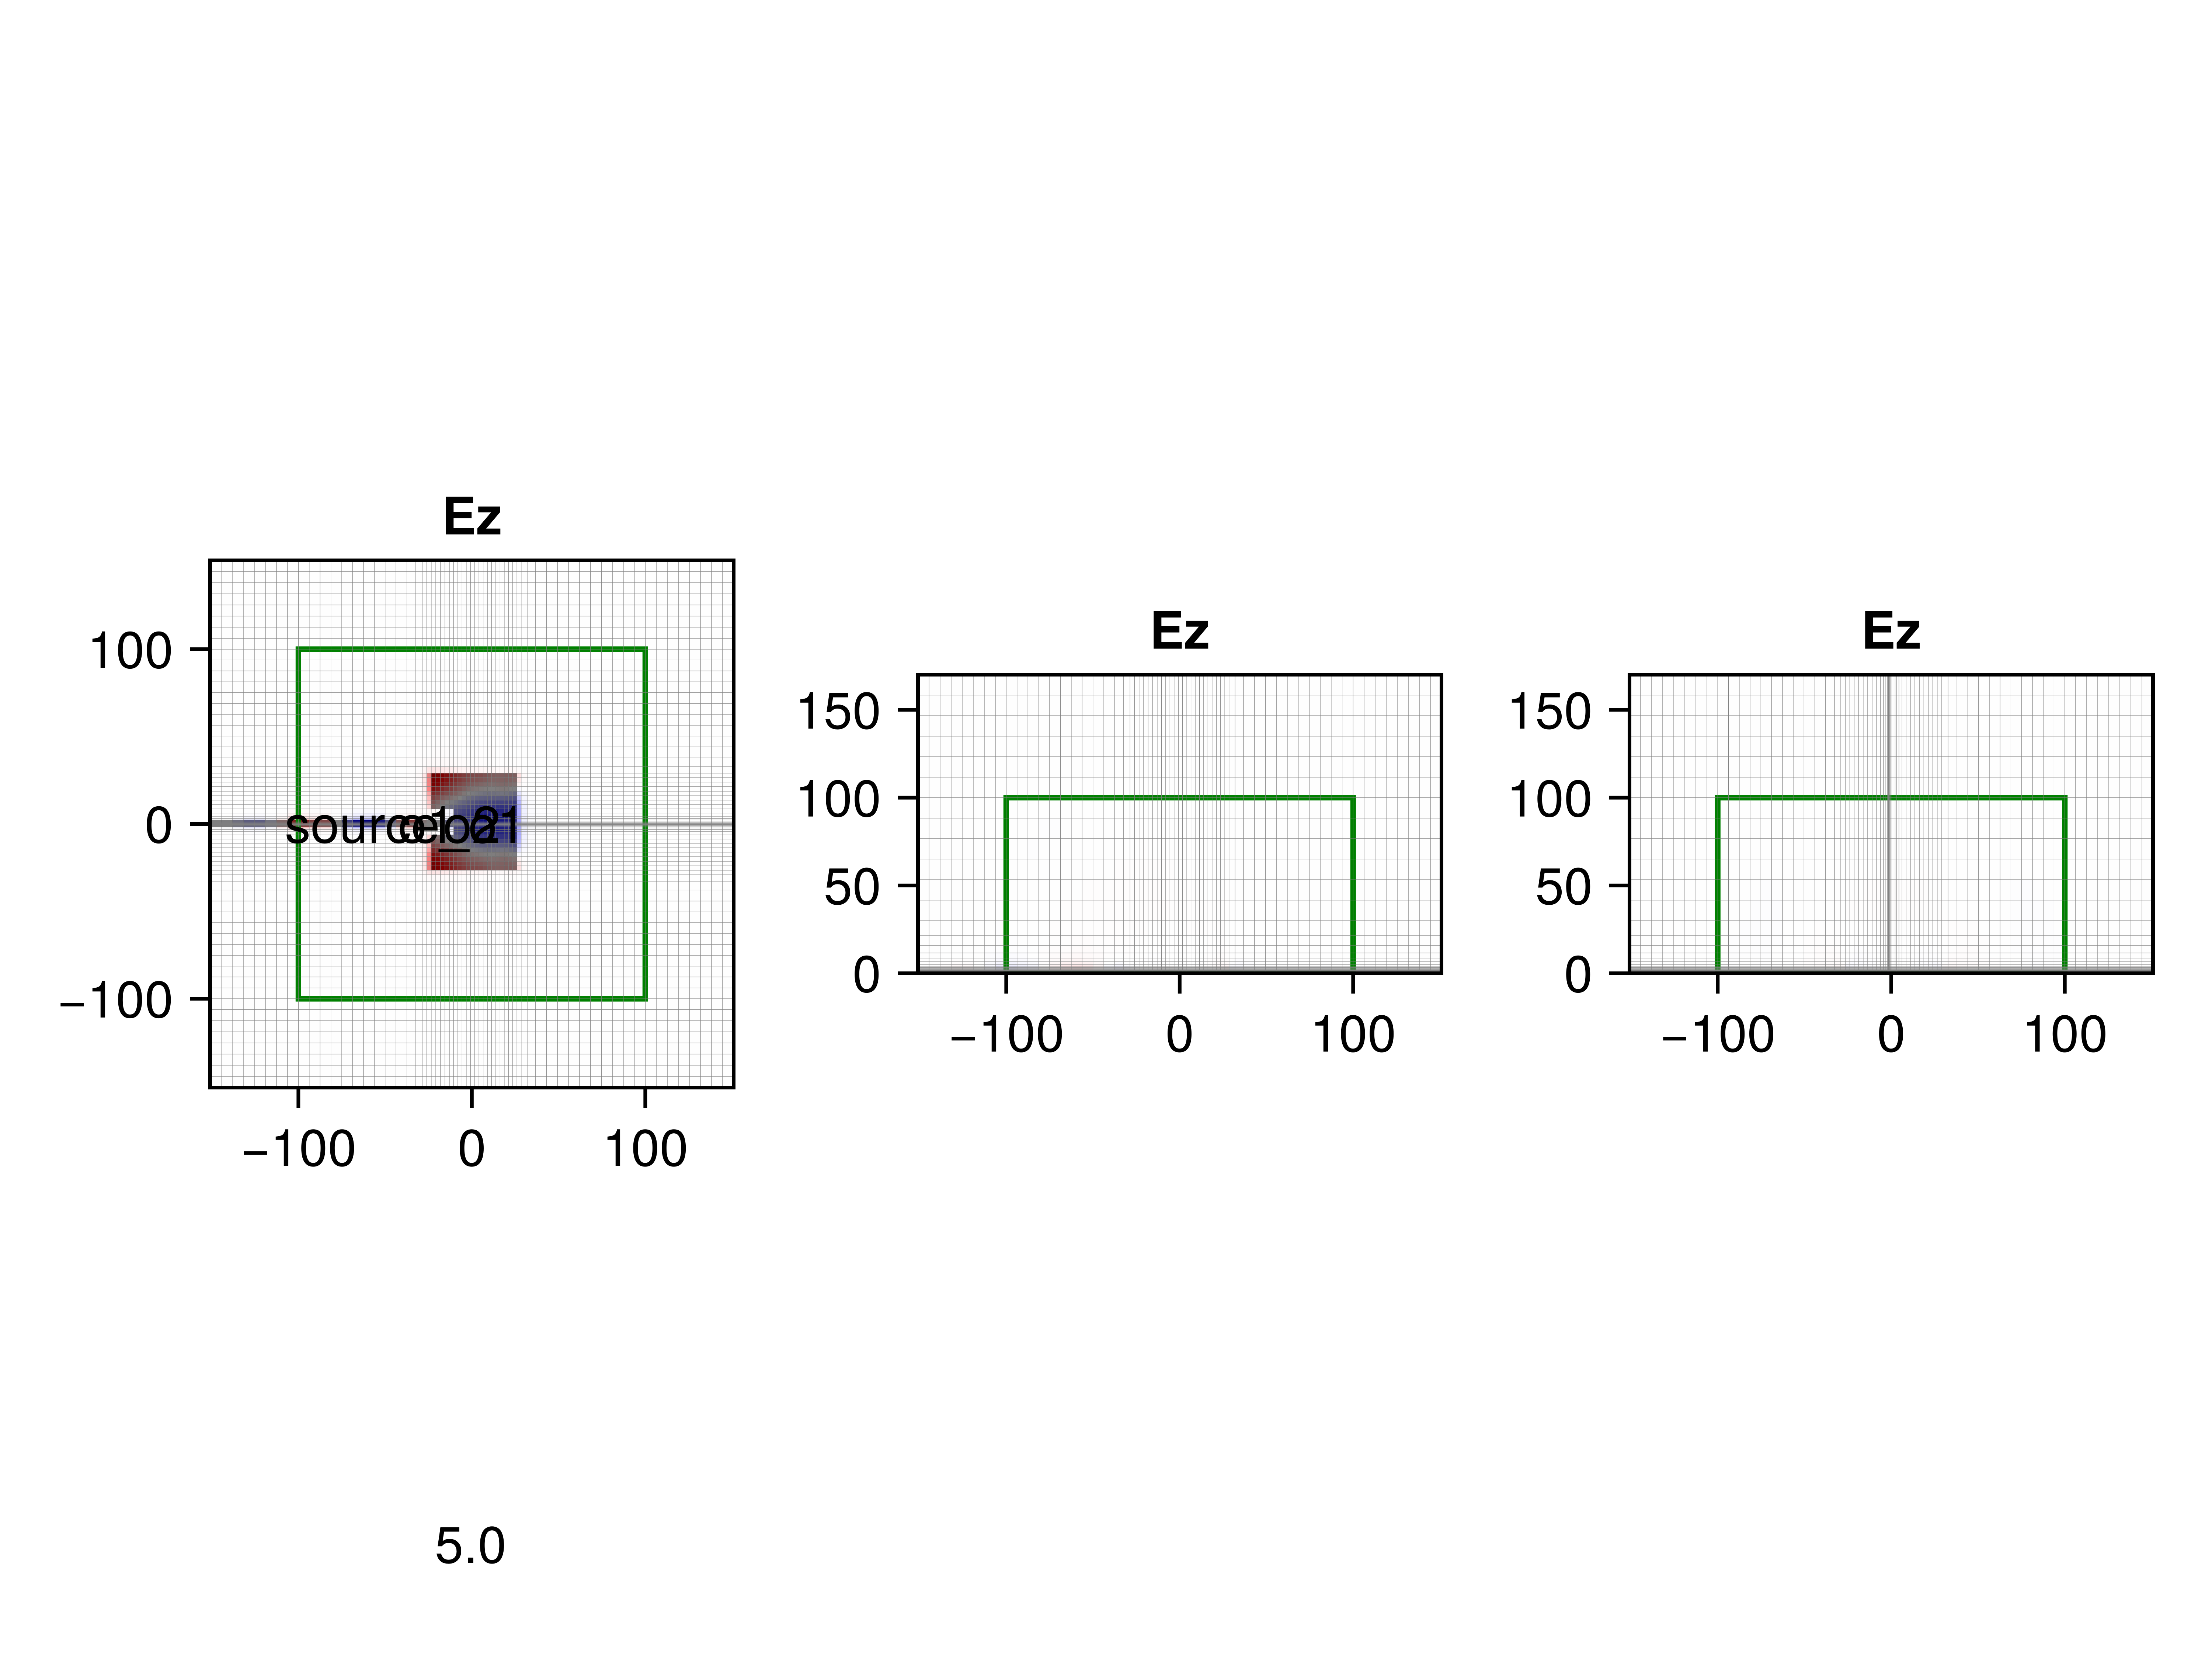

In [4]:
# adaptive meshing
nres = 16 # points per wavelength in material
dx0 = wavelength / nres  # mesh step in air

layer_stack = LayerStack(
    layers={
        "patch": LayerLevel(
            layer=LogicalLayer(layer=PATCH),
            zmin=d,
            thickness=th,
            material="PEC_patch",
            mesh_order=1,
        ),
        "line": LayerLevel(
            layer=LogicalLayer(layer=WG),
            zmin=d,
            thickness=th,
            material="PEC_line",
            mesh_order=2,
        ),
        "core": LayerLevel(
            layer=LogicalLayer(layer=SUB),
            zmin=0.0,
            thickness=d,
            material="substrate",
            mesh_order=3,
        ),
    }
)

dx_line = w_line / 5  # 5 mesh points across the strip
dx_patch = l_patch / 20  # 20 mesh points across the patch

eps_substrate = 3.38
n_substrate = np.sqrt(eps_substrate)

materials_library = {
    "air": lumi.Material(),
    "substrate": lumi.Material(epsilon=eps_substrate),
    "PEC_patch": lumi.PECMaterial(mesh_density=dx0/dx_patch),
    "PEC_line": lumi.PECMaterial(mesh_density=[n_substrate, dx0/dx_line,1]),
    'background': lumi.Material(),
}

# radiation port
R=H = (w_sub) / 2
angres=np.deg2rad(5)
θmax=np.deg2rad(80) # avoid microstrip
φmax=np.deg2rad(360)
ports = [
    lumi.SpherePort(
        name="o2",
        center=(0, 0, 0),
        radius=R,
        angres=angres,
        θmax=θmax,
        φmax=φmax,
    ),
]

# microstrip mode
modes = [
    lumi.Mode(
        ports=["o1"],
        frequency=frequency,
        metallic_boundaries=["-y", "line"],
        nmodes=1,
    )
]

sources = [
    lumi.Source(
        "o1", frequency=frequency, duration=1, source_port_margin=source_port_margin
    )
]


kwargs = dict(
    path=path,  # path to make problem folder
    component=c,
    frequencies=frequencies,
    frequency=frequency,
    wl1f=wl1f,
    boundaries=["PML", "PML", ["PEC", "PML"]],

    # 
    ports=ports,
    modes=modes,
    sources=sources,
    #
    lateral_port_margin=lateral_port_margin,
    height_port_margin=[0, height_port_margin],
    zmin=0,
    zmax=H,
    #
    materials_library=materials_library,
    layer_stack=layer_stack,
    #
    gpu="CUDA",
    nres=nres,  # number of grid points per wavelength in material (not vacuum)
    relative_courant=0.9,
    field_decay_threshold=1e-2,
    # 
    saveat=2.5, # save frame every _ periods for movie
    field_slices=[None,None,d / 2],
    geometry_slices=[None,None, d+th / 2],
    show_field="Ez",
    force=True,  # overwrite files in existing path
)
lumi.make(**kwargs)
# lumi.solve(path)
lumi.plot(path)
display(Image(filename=os.path.join(path, "peak.png")))

## Analysis

loading solution from c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\patch


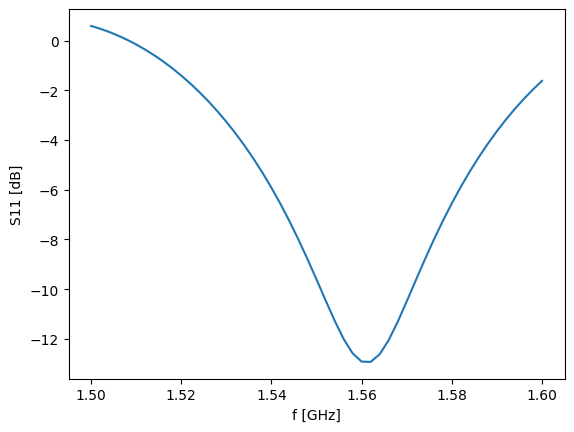

Text(0.5, 1.0, 'H-Plane Radiation Pattern')

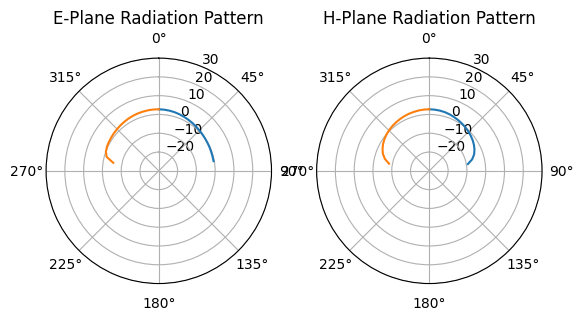

In [ ]:
sol = lumi.load(path)

# S11 plot
fig = plt.figure()
x = frequencies
y = [10 * np.log10(v) for v in lumi.query(sol, "T1,1")]
# y = [10 * math.log10(v) for v in lumi.query(sol, "To2@0,o1@0")]

plt.plot(x, y)
plt.xlabel("f [GHz]")
plt.ylabel("S11 [dB]")
plt.show()

flux = sol["dBi"]["o2"] # can append after o2 @H, V, L or R for polarization
i = np.argmin(y)
nφ = round(φmax / angres) + 1
nθ = round(θmax / angres) + 1
θ = np.linspace(0, θmax, nθ)

# Radiation pattern plots
flux_E_plane1 = flux[:, 0, i]
flux_E_plane2 = flux[:, round((nφ - 1) / 2), i]

flux_H_plane1 = flux[:, round((nφ - 1) / 4), i]
flux_H_plane2 = flux[:, round((nφ - 1) / 4 * 3), i]

fig = plt.figure()

ax = fig.add_subplot(121, polar=True)
ax.set_theta_zero_location("N")
ax.set_theta_direction("clockwise")
ax.plot(θ, flux_E_plane1)
ax.plot(-θ, flux_E_plane2)
ax.set_title("E-Plane Radiation Pattern")
ax.set_ylim(-30, 30)

ax = fig.add_subplot(122, polar=True)
ax.set_theta_zero_location("N")
ax.set_theta_direction("clockwise")
ax.plot(θ, flux_H_plane1)
ax.plot(-θ, flux_H_plane2)
ax.set_ylim(-30, 30)
ax.set_title("H-Plane Radiation Pattern")